In [34]:
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import random
import pickle
import os

# Load the provided dataset
data_path = 'weather_prediction_dataset_cleaned.pkl'
data = pd.read_pickle(data_path)

# Check the structure and contents of the dataset
data.info(), data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3654 entries, 0 to 3653
Columns: 165 entries, DATE to TOURS_temp_max
dtypes: float64(151), int64(13), object(1)
memory usage: 4.6+ MB


(None,
          DATE  MONTH  BASEL_cloud_cover  BASEL_humidity  BASEL_pressure  \
 0  2000-01-01      1                  8            0.89          1.0286   
 1  2000-01-02      1                  8            0.87          1.0318   
 2  2000-01-03      1                  5            0.81          1.0314   
 3  2000-01-04      1                  7            0.79          1.0262   
 4  2000-01-05      1                  5            0.90          1.0246   
 
    BASEL_global_radiation  BASEL_precipitation  BASEL_sunshine  \
 0                    0.20                 0.03             0.0   
 1                    0.25                 0.00             0.0   
 2                    0.50                 0.00             3.7   
 3                    0.63                 0.35             6.9   
 4                    0.51                 0.07             3.7   
 
    BASEL_temp_mean  BASEL_temp_min  ...  STOCKHOLM_temp_min  \
 0              2.9             1.6  ...                -9.3   
 1 

In [18]:
# Define a target change in sunshine prediction
desired_change = 1  # Example: we want the prediction to increase by 1

In [19]:
# Limit the number of rows to display for counterfactuals
num_samples_to_display = 3  # Only display results for 3 samples
num_features_to_modify = 2  # Only modify the top 2 most important features based on SHAP

In [21]:
cities = [col.rsplit('_', 1)[0] for col in data.columns if col.endswith('_sunshine')]
# Iterate over each city in the list of cities
city_models = {}
for city in cities:
    # Select feature columns and target column for the city
    feature_columns = [col for col in data.columns if col.startswith(city) and not col.endswith('_sunshine')]
    target_column = f'{city}_sunshine'

    # Create the feature matrix (X) by selecting the feature columns from the dataset
    X = data[feature_columns]
    
    # Create the target vector (y) by selecting the target column from the dataset
    y = data[target_column]

    # Split the data into training and testing sets (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define a simple CNN model
    cnn_model = models.Sequential([
        layers.Input(shape=(X_train.shape[1], 1)),
        layers.Conv1D(64, kernel_size=3, activation='relu'),
        layers.Conv1D(32, kernel_size=3, activation='relu'),
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dense(1) 
    ])
    
    cnn_model.compile(optimizer='adam', loss='mean_squared_error')

    history = cnn_model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32, verbose=0)

    y_pred_train = cnn_model.predict(X_train)
    y_pred_test = cnn_model.predict(X_test)
    
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)
    print(f"City: {city}, train_mse: {train_mse}, test_mse: {test_mse}, test_r2: {test_r2}")
    city_models[city] = cnn_model
     # Save the model as a pickle file
    with open(f"cnn_models/{city}_cnn_model.pkl", "wb") as model_file:
        pickle.dump(cnn_model, model_file)


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
City: BASEL, train_mse: 1.520035929571917, test_mse: 1.4054963928085744, test_r2: 0.9271165015737926
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
City: BUDAPEST, train_mse: 1.4549699925521369, test_mse: 1.4137359499631732, test_r2: 0.9293180725563637
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
City: DEBILT, train_mse: 1.481931825475934, test_mse: 1.5078271111625992, test_r2: 0.9029715431506813
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
City: DRESDEN, train_mse: 1.7021312526834242, test_mse: 1.9248024722729276, test_r2: 0.9058220582049451
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
City: DUSSELDORF, train_mse: 1.1539912484961607, test_mse: 1.1203614600997285, test_r2: 0.9387995157404481
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


ExactExplainer explainer: 732it [00:22, 18.36it/s]                                                                     


SHAP Summary Plot for BASEL:


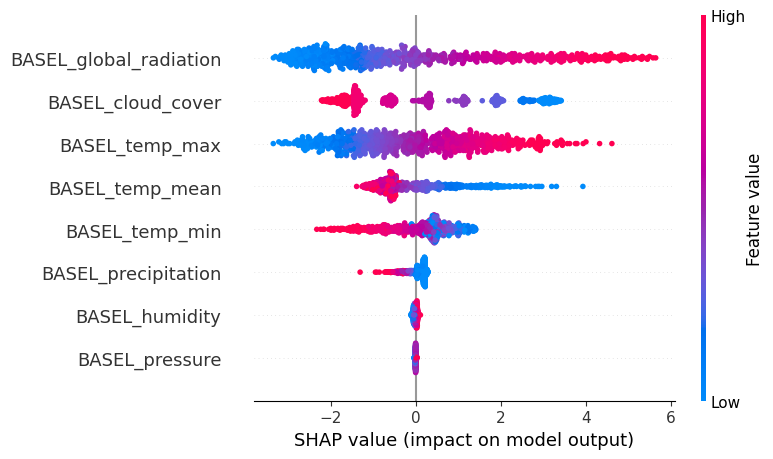

SHAP Dependence Plot for BASEL (first feature):


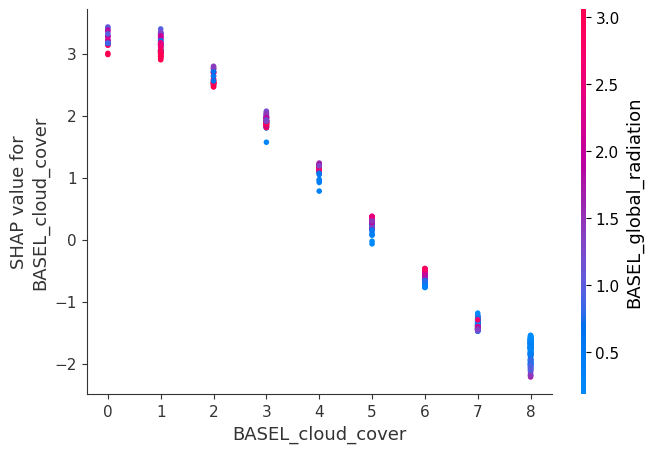


Counterfactual explanation for sample 543 with original prediction: [3.2]
Modified feature values to achieve new prediction: [4.2]
Feature Modifications:
                             Feature  Original Value  Modified Value
BASEL_temp_max        BASEL_temp_max             7.6           12.31
BASEL_cloud_cover  BASEL_cloud_cover             7.0            7.00


Counterfactual explanation for sample 659 with original prediction: [-0.44]
Modified feature values to achieve new prediction: [0.57]
Feature Modifications:
                                       Feature  Original Value  Modified Value
BASEL_global_radiation  BASEL_global_radiation            0.18            1.21
BASEL_cloud_cover            BASEL_cloud_cover            8.00            8.00


Counterfactual explanation for sample 110 with original prediction: [15.3]
Modified feature values to achieve new prediction: [16.32]
Feature Modifications:
                                       Feature  Original Value  Modified Value
BASE

ExactExplainer explainer: 732it [00:14, 15.87it/s]                                                                     


SHAP Summary Plot for BUDAPEST:


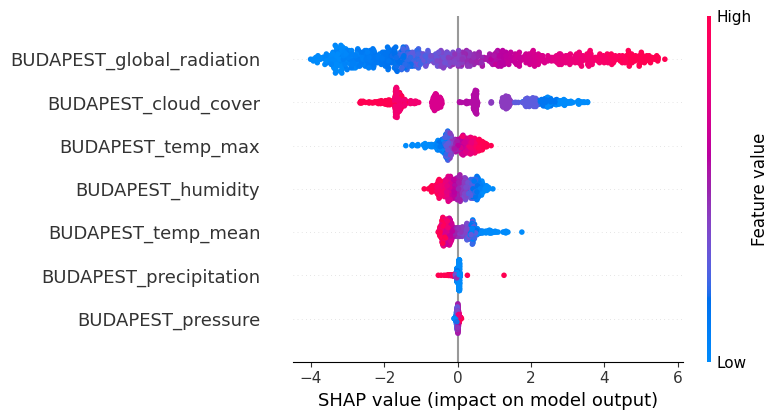

SHAP Dependence Plot for BUDAPEST (first feature):


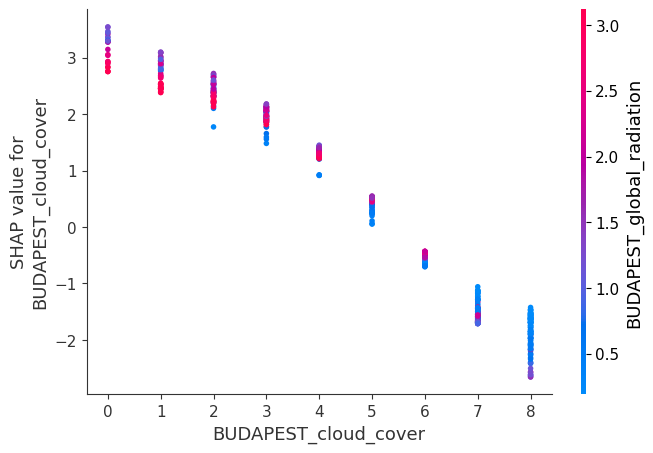


Counterfactual explanation for sample 263 with original prediction: [13.]
Modified feature values to achieve new prediction: [14.02]
Feature Modifications:
                                             Feature  Original Value  \
BUDAPEST_global_radiation  BUDAPEST_global_radiation            3.28   
BUDAPEST_cloud_cover            BUDAPEST_cloud_cover            3.00   

                           Modified Value  
BUDAPEST_global_radiation            3.67  
BUDAPEST_cloud_cover                 3.00  


Counterfactual explanation for sample 77 with original prediction: [0.1]
Modified feature values to achieve new prediction: [1.11]
Feature Modifications:
                                             Feature  Original Value  \
BUDAPEST_global_radiation  BUDAPEST_global_radiation            0.43   
BUDAPEST_cloud_cover            BUDAPEST_cloud_cover            7.00   

                           Modified Value  
BUDAPEST_global_radiation            0.96  
BUDAPEST_cloud_cover             

ExactExplainer explainer: 732it [01:47,  6.05it/s]                                                                     


SHAP Summary Plot for DEBILT:


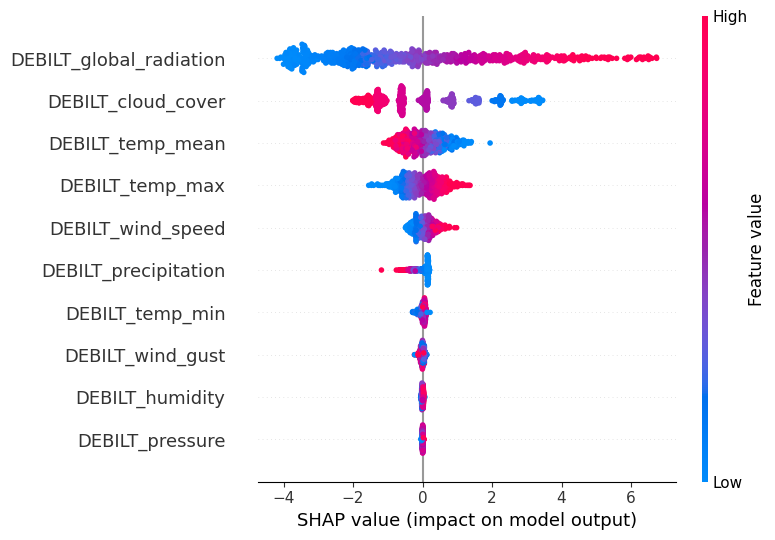

SHAP Dependence Plot for DEBILT (first feature):


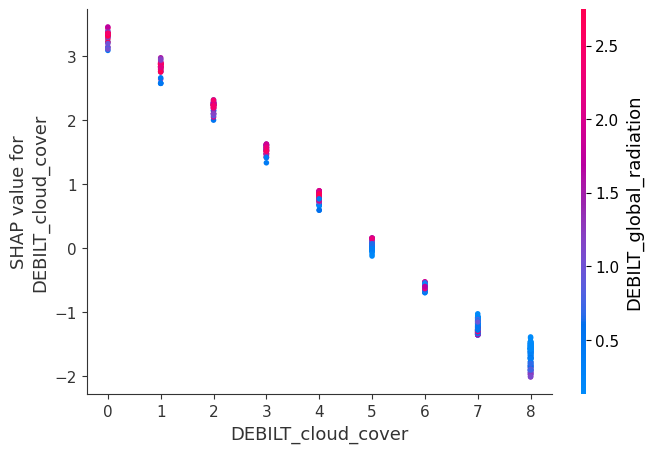


Counterfactual explanation for sample 121 with original prediction: [-0.44]
Modified feature values to achieve new prediction: [0.59]
Feature Modifications:
                                         Feature  Original Value  \
DEBILT_global_radiation  DEBILT_global_radiation            0.11   
DEBILT_cloud_cover            DEBILT_cloud_cover            8.00   

                         Modified Value  
DEBILT_global_radiation            0.26  
DEBILT_cloud_cover                 8.00  


Counterfactual explanation for sample 647 with original prediction: [7.57]
Modified feature values to achieve new prediction: [6.56]
Feature Modifications:
                                         Feature  Original Value  \
DEBILT_cloud_cover            DEBILT_cloud_cover            3.00   
DEBILT_global_radiation  DEBILT_global_radiation            1.54   

                         Modified Value  
DEBILT_cloud_cover                 4.48  
DEBILT_global_radiation            1.54  


Counterfactual expla

ExactExplainer explainer: 732it [00:52, 11.21it/s]                                                                     


SHAP Summary Plot for DRESDEN:


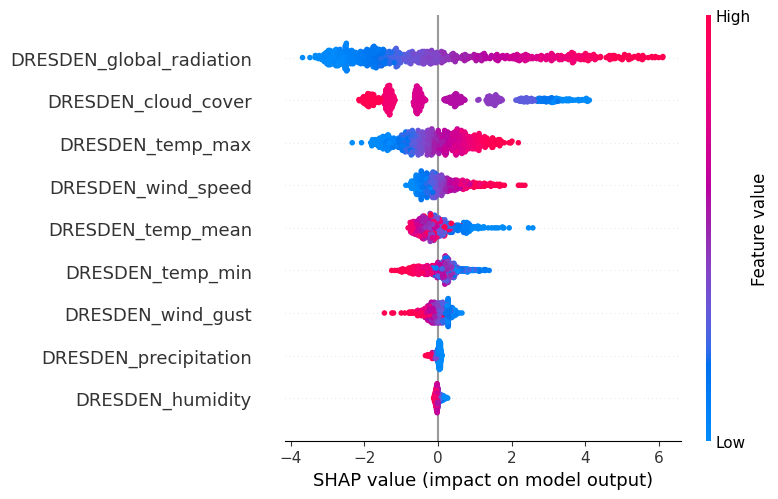

SHAP Dependence Plot for DRESDEN (first feature):


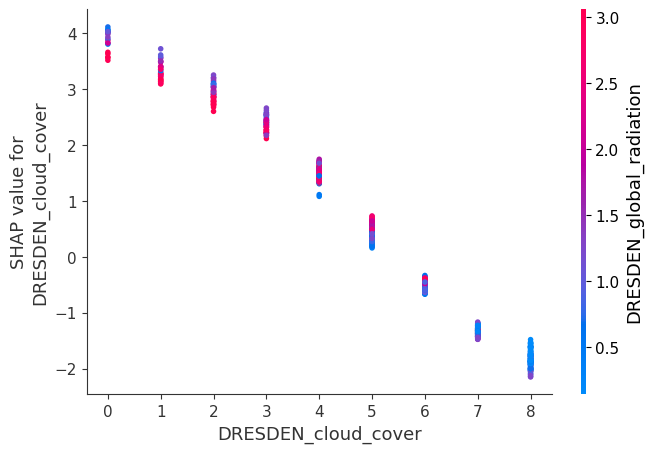


Counterfactual explanation for sample 202 with original prediction: [6.44]
Modified feature values to achieve new prediction: [5.44]
Feature Modifications:
                                 Feature  Original Value  Modified Value
DRESDEN_cloud_cover  DRESDEN_cloud_cover             4.0            4.91
DRESDEN_temp_max        DRESDEN_temp_max             2.9            2.90


Counterfactual explanation for sample 277 with original prediction: [2.89]
Modified feature values to achieve new prediction: [1.89]
Feature Modifications:
                                 Feature  Original Value  Modified Value
DRESDEN_cloud_cover  DRESDEN_cloud_cover             7.0            8.82
DRESDEN_temp_mean      DRESDEN_temp_mean             9.9            9.90


Counterfactual explanation for sample 153 with original prediction: [5.14]
Modified feature values to achieve new prediction: [6.17]
Feature Modifications:
                                           Feature  Original Value  \
DRESDEN_global_radi

ExactExplainer explainer: 732it [02:41,  4.11it/s]                                                                     


SHAP Summary Plot for DUSSELDORF:


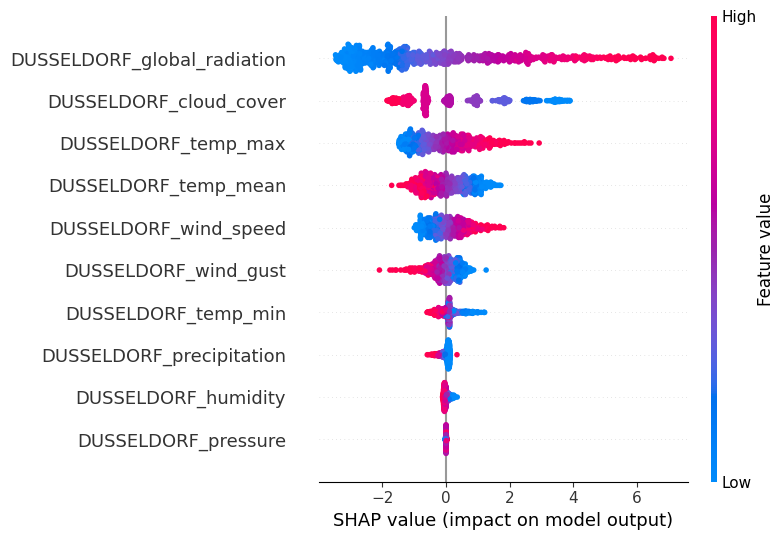

SHAP Dependence Plot for DUSSELDORF (first feature):


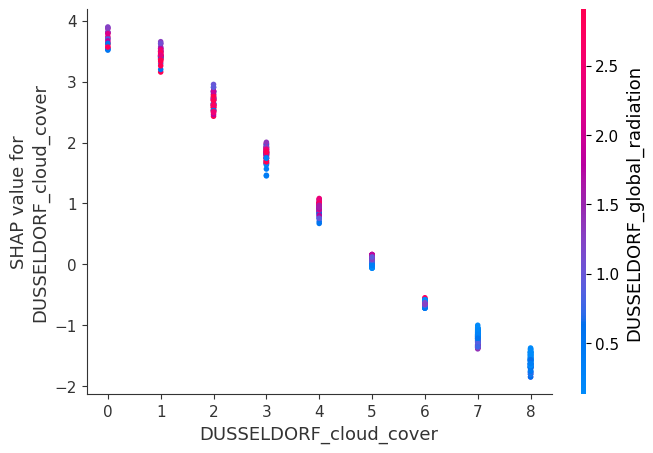


Counterfactual explanation for sample 7 with original prediction: [4.64]
Modified feature values to achieve new prediction: [3.63]
Feature Modifications:
                                       Feature  Original Value  Modified Value
DUSSELDORF_cloud_cover  DUSSELDORF_cloud_cover             3.0            4.13
DUSSELDORF_wind_speed    DUSSELDORF_wind_speed             7.0            7.00


Counterfactual explanation for sample 139 with original prediction: [1.17]
Modified feature values to achieve new prediction: [2.18]
Feature Modifications:
                                                 Feature  Original Value  \
DUSSELDORF_global_radiation  DUSSELDORF_global_radiation            0.43   
DUSSELDORF_temp_max                  DUSSELDORF_temp_max            3.20   

                             Modified Value  
DUSSELDORF_global_radiation             1.0  
DUSSELDORF_temp_max                     3.2  


Counterfactual explanation for sample 232 with original prediction: [2.04]
Modifi

ExactExplainer explainer: 732it [00:49, 11.85it/s]                                                                     


SHAP Summary Plot for HEATHROW:


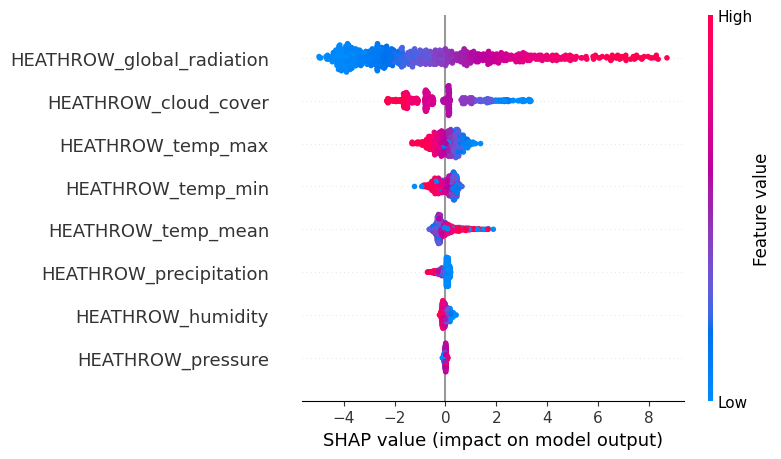

SHAP Dependence Plot for HEATHROW (first feature):


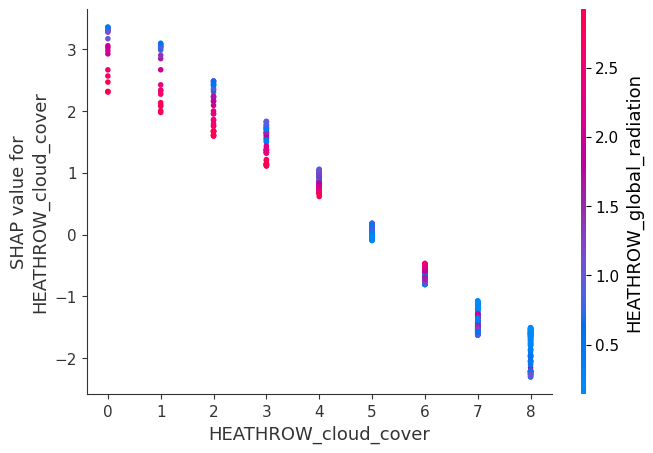


Counterfactual explanation for sample 96 with original prediction: [11.94]
Modified feature values to achieve new prediction: [12.96]
Feature Modifications:
                                             Feature  Original Value  \
HEATHROW_global_radiation  HEATHROW_global_radiation            2.95   
HEATHROW_cloud_cover            HEATHROW_cloud_cover            4.00   

                           Modified Value  
HEATHROW_global_radiation            3.19  
HEATHROW_cloud_cover                 4.00  


Counterfactual explanation for sample 552 with original prediction: [8.45]
Modified feature values to achieve new prediction: [7.44]
Feature Modifications:
                                             Feature  Original Value  \
HEATHROW_cloud_cover            HEATHROW_cloud_cover            3.00   
HEATHROW_global_radiation  HEATHROW_global_radiation            1.74   

                           Modified Value  
HEATHROW_cloud_cover                 4.37  
HEATHROW_global_radiation     

ExactExplainer explainer: 732it [01:23,  7.60it/s]                                                                     


SHAP Summary Plot for KASSEL:


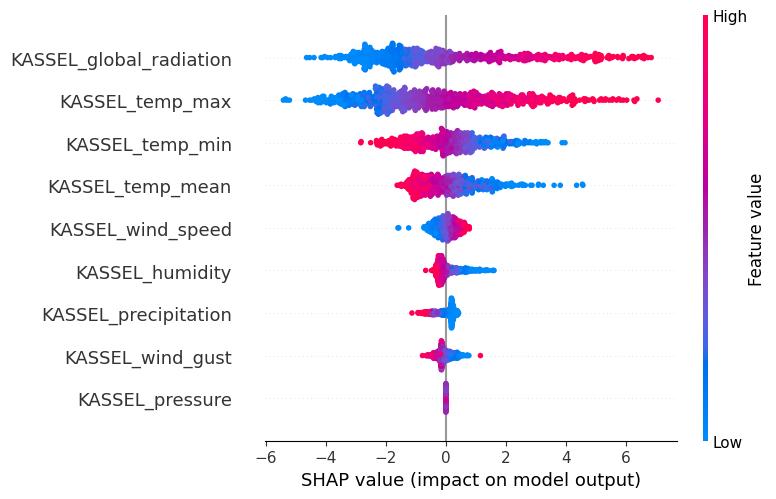

SHAP Dependence Plot for KASSEL (first feature):


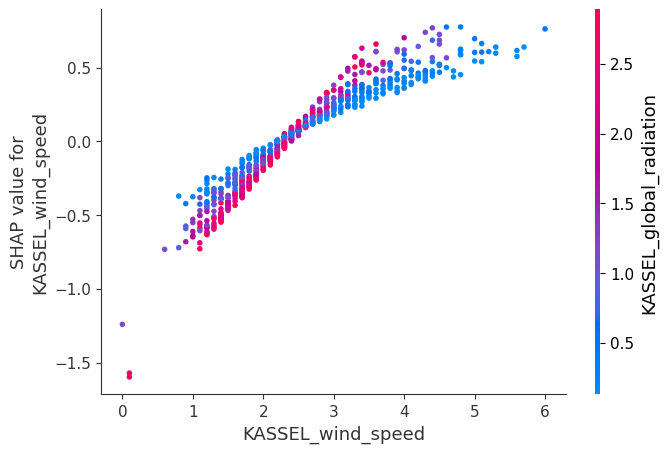


Counterfactual explanation for sample 468 with original prediction: [4.68]
Modified feature values to achieve new prediction: [5.68]
Feature Modifications:
                         Feature  Original Value  Modified Value
KASSEL_temp_max  KASSEL_temp_max            23.6           25.72
KASSEL_temp_min  KASSEL_temp_min            10.9           10.90


Counterfactual explanation for sample 323 with original prediction: [4.83]
Modified feature values to achieve new prediction: [5.83]
Feature Modifications:
                         Feature  Original Value  Modified Value
KASSEL_temp_max  KASSEL_temp_max             9.2           11.42
KASSEL_temp_min  KASSEL_temp_min             0.5            0.50


Counterfactual explanation for sample 230 with original prediction: [1.09]
Modified feature values to achieve new prediction: [2.1]
Feature Modifications:
                                         Feature  Original Value  \
KASSEL_global_radiation  KASSEL_global_radiation            0.83   
KA

ExactExplainer explainer: 732it [01:25,  7.56it/s]                                                                     


SHAP Summary Plot for LJUBLJANA:


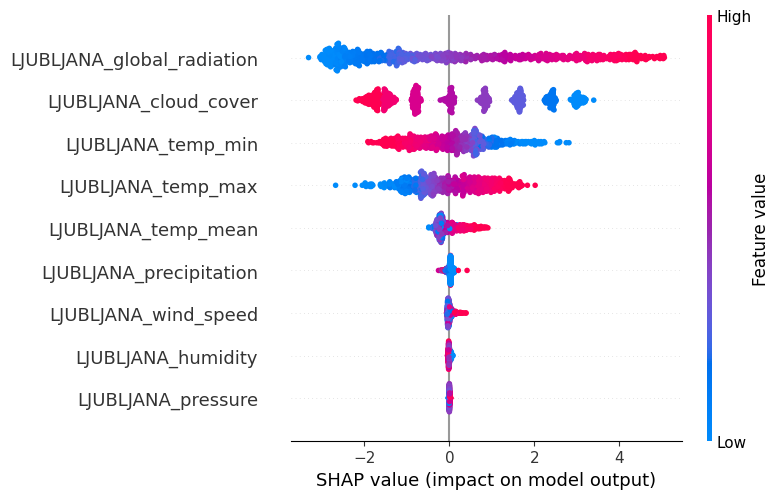

SHAP Dependence Plot for LJUBLJANA (first feature):


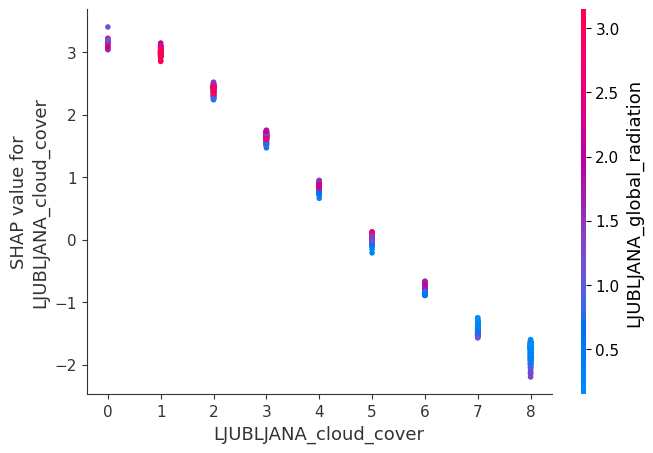


Counterfactual explanation for sample 344 with original prediction: [-0.56]
Modified feature values to achieve new prediction: [0.45]
Feature Modifications:
                                               Feature  Original Value  \
LJUBLJANA_global_radiation  LJUBLJANA_global_radiation            0.15   
LJUBLJANA_cloud_cover            LJUBLJANA_cloud_cover            8.00   

                            Modified Value  
LJUBLJANA_global_radiation            0.74  
LJUBLJANA_cloud_cover                 8.00  


Counterfactual explanation for sample 517 with original prediction: [-0.36]
Modified feature values to achieve new prediction: [0.66]
Feature Modifications:
                                               Feature  Original Value  \
LJUBLJANA_global_radiation  LJUBLJANA_global_radiation            0.25   
LJUBLJANA_cloud_cover            LJUBLJANA_cloud_cover            8.00   

                            Modified Value  
LJUBLJANA_global_radiation            0.97  
LJUBLJANA_cl

ExactExplainer explainer: 732it [02:44,  4.18it/s]                                                                     


SHAP Summary Plot for MAASTRICHT:


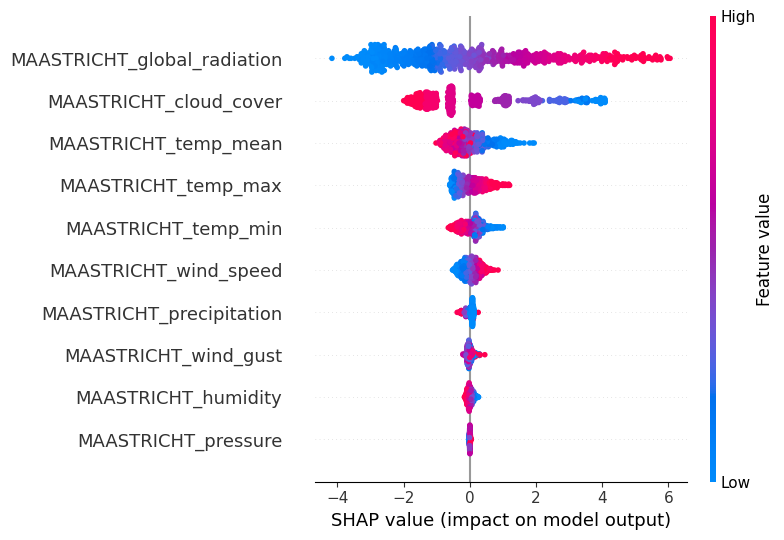

SHAP Dependence Plot for MAASTRICHT (first feature):


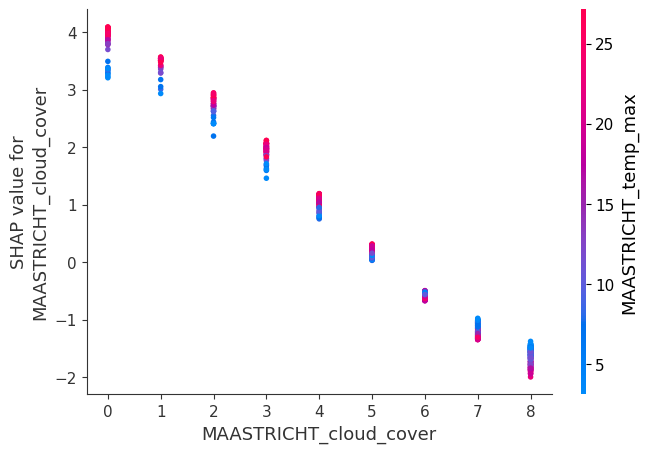


Counterfactual explanation for sample 44 with original prediction: [5.58]
Modified feature values to achieve new prediction: [6.58]
Feature Modifications:
                                                 Feature  Original Value  \
MAASTRICHT_global_radiation  MAASTRICHT_global_radiation            1.97   
MAASTRICHT_cloud_cover            MAASTRICHT_cloud_cover            6.00   

                             Modified Value  
MAASTRICHT_global_radiation            2.37  
MAASTRICHT_cloud_cover                 6.00  


Counterfactual explanation for sample 190 with original prediction: [9.58]
Modified feature values to achieve new prediction: [10.6]
Feature Modifications:
                                                 Feature  Original Value  \
MAASTRICHT_global_radiation  MAASTRICHT_global_radiation            2.27   
MAASTRICHT_cloud_cover            MAASTRICHT_cloud_cover            3.00   

                             Modified Value  
MAASTRICHT_global_radiation            2.62 

ExactExplainer explainer: 732it [01:44,  6.34it/s]                                                                     


SHAP Summary Plot for MUENCHEN:


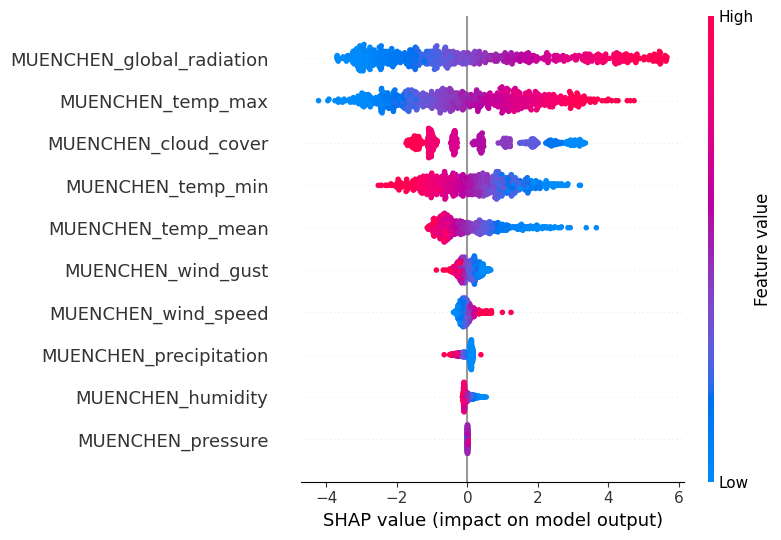

SHAP Dependence Plot for MUENCHEN (first feature):


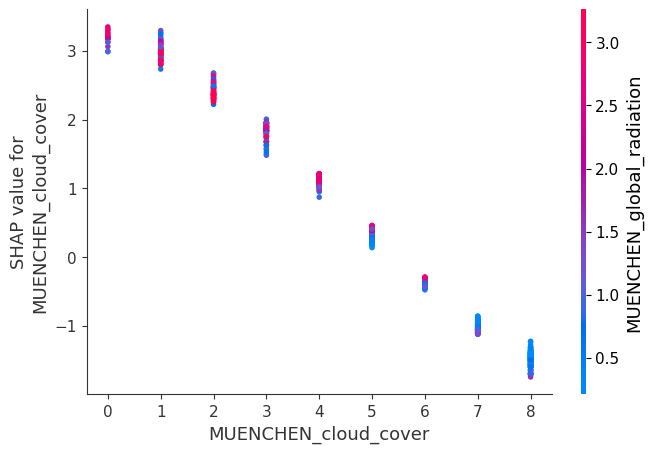


Counterfactual explanation for sample 708 with original prediction: [6.15]
Modified feature values to achieve new prediction: [7.16]
Feature Modifications:
                                             Feature  Original Value  \
MUENCHEN_temp_max                  MUENCHEN_temp_max           29.80   
MUENCHEN_global_radiation  MUENCHEN_global_radiation            2.23   

                           Modified Value  
MUENCHEN_temp_max                   33.55  
MUENCHEN_global_radiation            2.23  


Counterfactual explanation for sample 533 with original prediction: [2.09]
Modified feature values to achieve new prediction: [3.09]
Feature Modifications:
                                             Feature  Original Value  \
MUENCHEN_temp_max                  MUENCHEN_temp_max            0.70   
MUENCHEN_global_radiation  MUENCHEN_global_radiation            0.43   

                           Modified Value  
MUENCHEN_temp_max                    3.32  
MUENCHEN_global_radiation      

ExactExplainer explainer: 732it [01:22,  7.79it/s]                                                                     


SHAP Summary Plot for OSLO:


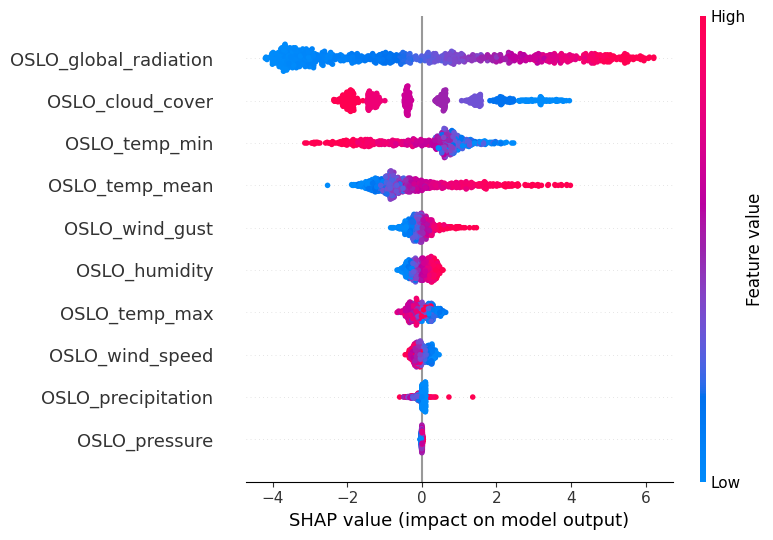

SHAP Dependence Plot for OSLO (first feature):


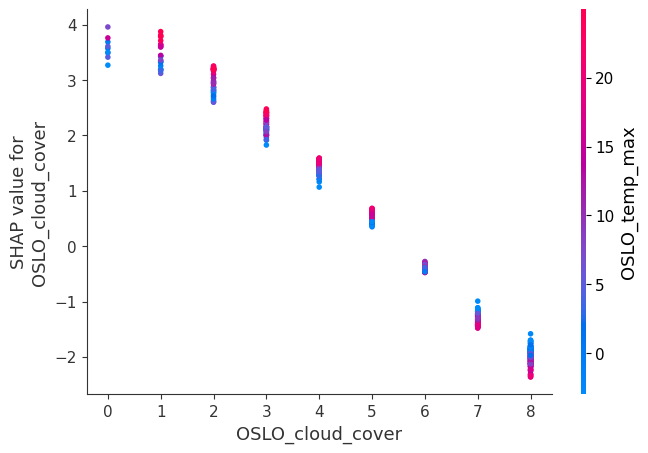


Counterfactual explanation for sample 408 with original prediction: [3.65]
Modified feature values to achieve new prediction: [4.67]
Feature Modifications:
                                     Feature  Original Value  Modified Value
OSLO_global_radiation  OSLO_global_radiation            0.36            0.55
OSLO_cloud_cover            OSLO_cloud_cover            7.00            7.00


Counterfactual explanation for sample 297 with original prediction: [6.03]
Modified feature values to achieve new prediction: [5.03]
Feature Modifications:
                       Feature  Original Value  Modified Value
OSLO_temp_min    OSLO_temp_min            -0.7            8.97
OSLO_temp_mean  OSLO_temp_mean             3.7            3.70


Counterfactual explanation for sample 460 with original prediction: [3.87]
Modified feature values to achieve new prediction: [2.87]
Feature Modifications:
                                     Feature  Original Value  Modified Value
OSLO_cloud_cover            OS

ExactExplainer explainer: 732it [00:14, 15.35it/s]                                                                     


SHAP Summary Plot for ROMA:


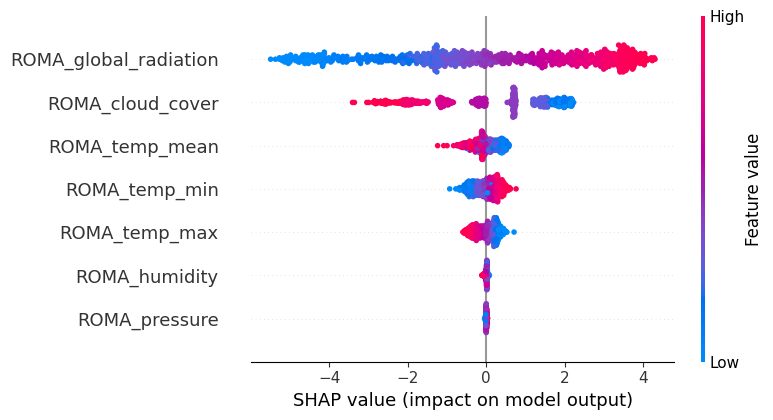

SHAP Dependence Plot for ROMA (first feature):


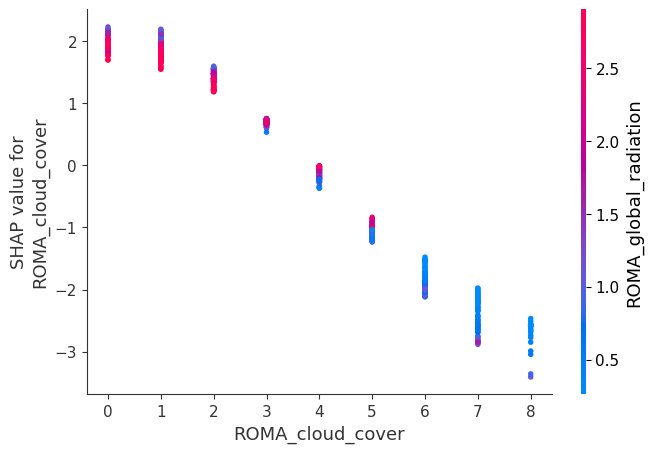


Counterfactual explanation for sample 227 with original prediction: [11.65]
Modified feature values to achieve new prediction: [12.67]
Feature Modifications:
                                     Feature  Original Value  Modified Value
ROMA_global_radiation  ROMA_global_radiation             2.9            3.33
ROMA_cloud_cover            ROMA_cloud_cover             2.0            2.00


Counterfactual explanation for sample 461 with original prediction: [5.22]
Modified feature values to achieve new prediction: [4.21]
Feature Modifications:
                                     Feature  Original Value  Modified Value
ROMA_cloud_cover            ROMA_cloud_cover            5.00            5.98
ROMA_global_radiation  ROMA_global_radiation            1.18            1.18


Counterfactual explanation for sample 327 with original prediction: [2.53]
Modified feature values to achieve new prediction: [1.53]
Feature Modifications:
                                     Feature  Original Value  M

ExactExplainer explainer: 732it [00:13, 14.27it/s]                                                                     


SHAP Summary Plot for SONNBLICK:


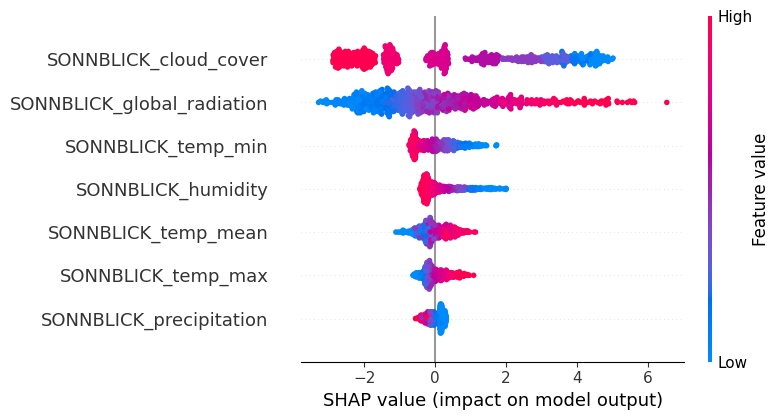

SHAP Dependence Plot for SONNBLICK (first feature):


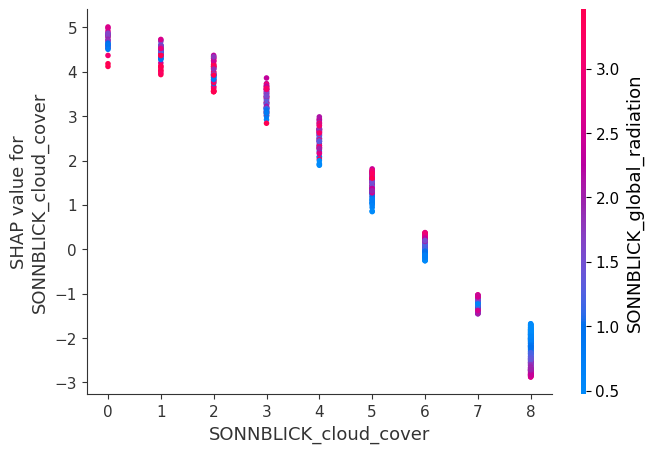


Counterfactual explanation for sample 711 with original prediction: [10.22]
Modified feature values to achieve new prediction: [11.24]
Feature Modifications:
                                               Feature  Original Value  \
SONNBLICK_global_radiation  SONNBLICK_global_radiation            2.72   
SONNBLICK_cloud_cover            SONNBLICK_cloud_cover            4.00   

                            Modified Value  
SONNBLICK_global_radiation            3.11  
SONNBLICK_cloud_cover                 4.00  


Counterfactual explanation for sample 224 with original prediction: [12.27]
Modified feature values to achieve new prediction: [11.26]
Feature Modifications:
                                               Feature  Original Value  \
SONNBLICK_cloud_cover            SONNBLICK_cloud_cover             2.0   
SONNBLICK_global_radiation  SONNBLICK_global_radiation             3.2   

                            Modified Value  
SONNBLICK_cloud_cover                 3.62  
SONNBLICK_

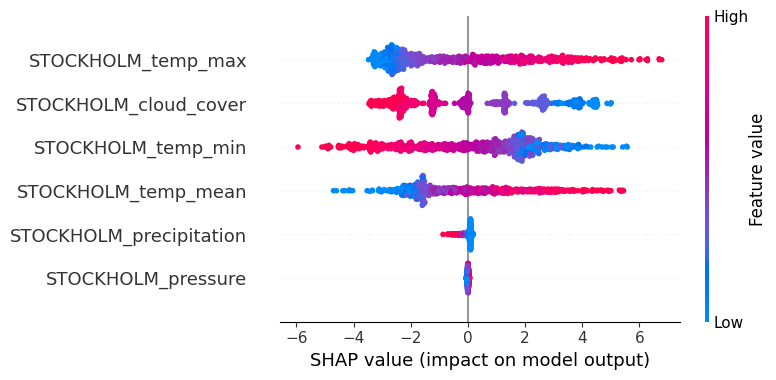

SHAP Dependence Plot for STOCKHOLM (first feature):


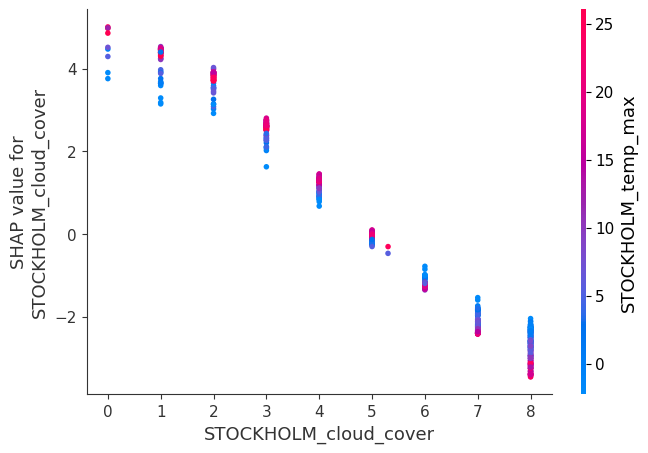


Counterfactual explanation for sample 471 with original prediction: [12.17]
Modified feature values to achieve new prediction: [13.17]
Feature Modifications:
                                 Feature  Original Value  Modified Value
STOCKHOLM_temp_max    STOCKHOLM_temp_max            22.5           24.31
STOCKHOLM_temp_mean  STOCKHOLM_temp_mean            16.9           16.90


Counterfactual explanation for sample 426 with original prediction: [1.92]
Modified feature values to achieve new prediction: [0.92]
Feature Modifications:
                                     Feature  Original Value  Modified Value
STOCKHOLM_temp_min        STOCKHOLM_temp_min            18.6           20.86
STOCKHOLM_cloud_cover  STOCKHOLM_cloud_cover             8.0            8.00


Counterfactual explanation for sample 76 with original prediction: [0.03]
Modified feature values to achieve new prediction: [-0.97]
Feature Modifications:
                                     Feature  Original Value  Modified Valu

In [31]:
for city in cities:
    # Initialize an empty list to hold the feature columns for the current city
    feature_columns = []
    
    # Iterate over all columns in the dataset to identify feature columns
    for col in data.columns:
        # Check if the column name starts with the current city and does not end with '_sunshine'
        if col.startswith(city) and not col.endswith('_sunshine'):
            # If the condition is met, add the column to the feature_columns list
            feature_columns.append(col)
    
    # Define the target column for the current city
    target_column = f'{city}_sunshine'
    
    # Check if the target column (e.g., 'city_sunshine') exists in the dataset
    if target_column not in data.columns:
        # If the target column is missing, print a message and skip the current city
        print(f"Skipping {city} because no '_sunshine' column is present.")
        continue

    with open(f"cnn_models/{city}_cnn_model.pkl", "rb") as model_file:
        cnn_model = pickle.load(model_file)

    # Create the feature matrix (X) by selecting the feature columns from the dataset
    X = data[feature_columns]
    
    # Create the target vector (y) by selecting the target column from the dataset
    y = data[target_column]

    # Split the data into training and testing sets (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    y_pred = cnn_model.predict(X_test)
        
    explainer = shap.Explainer(cnn_model, X_train)
    shap_values = explainer(X_test)
    
    # Visualize SHAP values for feature importance (summary plot)
    print(f"SHAP Summary Plot for {city}:")
    shap.summary_plot(shap_values.values, X_test, feature_names=feature_columns)
    
    #  Visualize SHAP dependence for specific features
    print(f"SHAP Dependence Plot for {city} (first feature):")
    shap.dependence_plot(feature_columns[0], shap_values.values, X_test)
    
    # Randomly select a specified number of samples from the test data for counterfactual explanations
    num_samples = num_samples_to_display  # Define the number of samples to display
    random_samples_idx = random.sample(range(len(X_test)), num_samples)
    
    # Iterate over the randomly selected sample indices
    for idx in random_samples_idx:
        # Extract the feature values for the current sample (row) and create a copy
        x_instance = X_test.iloc[idx, :].copy()
        
        # Convert the extracted row to a one-row DataFrame to maintain column names
        x_instance = pd.DataFrame([x_instance], columns=X_test.columns)
        
        # Get the SHAP values for the current sample (idx)
        shap_values_current_sample = shap_values[idx].values
        
        # Sort the SHAP values by absolute value to identify the most important features
        sorted_feature_indices = np.argsort(-np.abs(shap_values_current_sample))
        
        # Select the top 'num_features_to_modify' features based on SHAP importance for this sample
        top_features_idx = sorted_feature_indices[:num_features_to_modify]
        
        # Create a list of the most important features for modification
        top_features = []
        for j in top_features_idx:
            top_features.append(feature_columns[j])
        
        # Store the original values of the top features before making modifications
        original_values = x_instance[top_features].copy()
        
        # Loop through the top features to modify them one by one
        for feature in top_features:
            # Set the step size for modifying the feature
            step_size = 0.01
            
            # Continue modifying the feature until the desired change in prediction is achieved
            current_difference = abs(cnn_model.predict(x_instance, verbose=0)[0] - y_pred[idx])
            while current_difference < desired_change:
                # Modify the feature value by adding the step size
                x_instance[feature] += step_size
                
                # Recalculate the prediction after the modification
                new_pred = cnn_model.predict(x_instance, verbose=0)[0]
                
                # Update the current difference between the new and old predictions
                current_difference = abs(new_pred - y_pred[idx])
        
        # After modifying the features, display the original and modified feature values
        modified_values = x_instance[top_features]
        
        # Create a DataFrame to show the original and modified values side by side
        changes = pd.DataFrame({
            'Feature': top_features,                # Feature names
            'Original Value': original_values.iloc[0],  # Original values before modification
            'Modified Value': modified_values.iloc[0]   # Modified values after modification
        })
        
        # Display the counterfactual explanation for the current sample
        print(f"\nCounterfactual explanation for sample {idx + 1} with original prediction: {np.around(y_pred[idx], 2)}")
        print(f"Modified feature values to achieve new prediction: {np.around(new_pred, 2)}")
        print(f"Feature Modifications:\n{changes}\n")
    
    
    # After processing the selected random samples, display a summary message
    print(f"Displayed {num_samples} random samples for {city}.")
    print("*" * 100)
    print(f"\n\n\n")

In [37]:
# Mean absolute SHAP values for each feature of each city
cities = [col.rsplit('_', 1)[0] for col in data.columns if col.endswith('_sunshine')]
general_feature_importance = {}

# Iterate over each city to load the saved Random Forest models and perform SHAP analysis
for city in cities:
    # Load the saved model for the city
    model_path = f"cnn_models/{city}_cnn_model.pkl"
    
    if os.path.exists(model_path):
        with open(model_path, "rb") as model_file:
            cnn_model = pickle.load(model_file)
        
        # Select feature columns and target column for the city
        feature_columns = [col for col in data.columns if col.startswith(city) and not col.endswith('_sunshine')]
        target_column = f'{city}_sunshine'
        
        # Check if the target column exists in the dataset
        if target_column not in data.columns:
            print(f"Skipping {city} because no '_sunshine' column is present.")
            continue
        
        X = data[feature_columns]
        y = data[target_column]
        
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Initialize the SHAP explainer for the CNN model
        explainer = shap.Explainer(cnn_model, X_train)
        shap_values = explainer(X_train)
        
        # Calculate the mean absolute SHAP values for each feature
        shap_importance = pd.DataFrame(shap_values.values, columns=feature_columns).abs().mean().to_dict()
        
        for feature in feature_columns:
            general_feature = feature[len(city) + 1:] 
            if general_feature not in general_feature_importance:
                general_feature_importance[general_feature] = {}
            general_feature_importance[general_feature][city] = shap_importance[feature]
        
    else:
        print(f"Model file for {city} not found.")

shap_importance_df = pd.DataFrame(general_feature_importance).T
print(shap_importance_df)

ExactExplainer explainer: 2924it [01:28, 29.21it/s]                                                                    
ExactExplainer explainer: 2924it [00:53, 44.57it/s]                                                                    
ExactExplainer explainer: 2924it [05:36,  8.43it/s]                                                                    
ExactExplainer explainer: 2924it [02:52, 16.00it/s]                                                                    
ExactExplainer explainer: 2924it [08:03,  5.91it/s]                                                                    
ExactExplainer explainer: 2924it [02:22, 19.23it/s]                                                                    
ExactExplainer explainer: 2924it [04:37, 10.11it/s]                                                                    
ExactExplainer explainer: 2924it [05:02,  9.20it/s]                                                                    
ExactExplainer explainer: 2924it [10:45,

                     BASEL  BUDAPEST    DEBILT   DRESDEN  DUSSELDORF  \
cloud_cover       1.483589  1.561626  1.250562  1.477763    1.255476   
humidity          0.029869  0.335310  0.015104  0.049028    0.057470   
pressure          0.006718  0.021653  0.008860       NaN    0.005178   
global_radiation  1.902029  2.281212  2.257916  2.044335    2.157157   
precipitation     0.184563  0.046340  0.161680  0.058449    0.093829   
temp_mean         0.752661  0.318301  0.457864  0.393404    0.617792   
temp_min          0.667310       NaN  0.058636  0.361032    0.222950   
temp_max          1.367284  0.330569  0.434199  0.752620    0.776526   
wind_speed             NaN       NaN  0.211194  0.417523    0.461111   
wind_gust              NaN       NaN  0.038094  0.227437    0.354022   

                  HEATHROW  LJUBLJANA  MAASTRICHT  MUENCHEN      OSLO  \
cloud_cover       1.157506   1.453077    1.422834  1.289198  1.568666   
humidity          0.092254   0.017397    0.057364  0.096471  

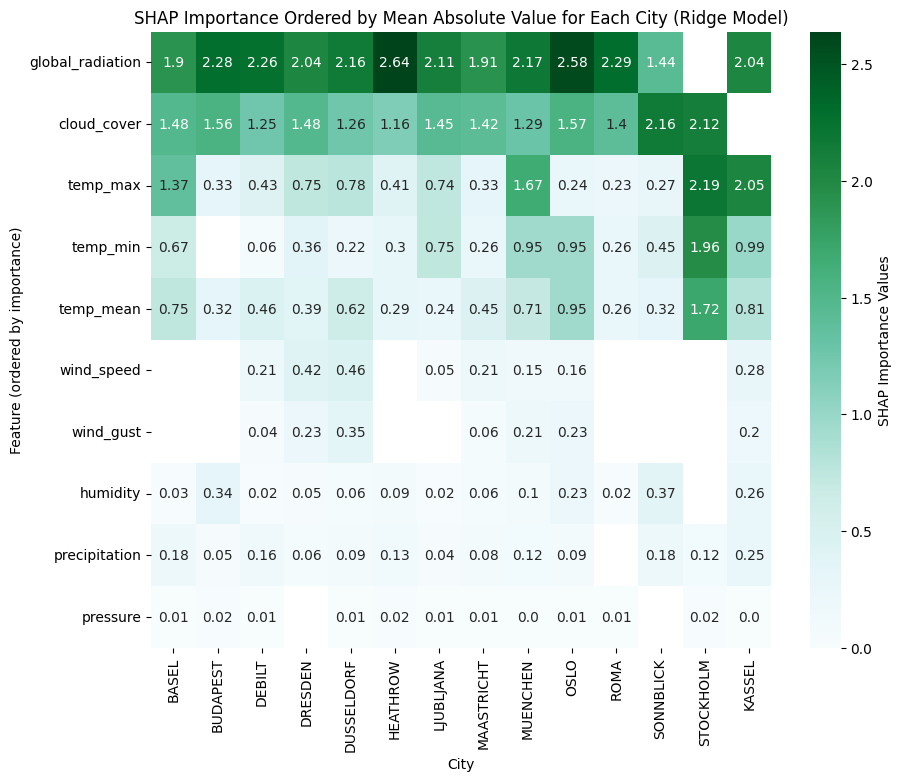

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
# Calculate the mean absolute value for each feature across all cities
mean_absolute_importance = shap_importance_df.abs().mean(axis=1)

# Sort the SHAP importance DataFrame by mean absolute importance in descending order
shap_importance_df = shap_importance_df.loc[mean_absolute_importance.sort_values(ascending=False).index]

# Round the sorted SHAP importance values for display
rounded_shap_importance_df = shap_importance_df.round(2)

# Creating a heatmap with features ordered by mean absolute importance
plt.figure(figsize=(10, 8))
sns.heatmap(rounded_shap_importance_df, annot=rounded_shap_importance_df, cmap='BuGn', fmt="", 
            cbar_kws={'label': 'SHAP Importance Values'})
plt.title("SHAP Importance Ordered by Mean Absolute Value for Each City (Ridge Model)")
plt.xlabel("City")
plt.ylabel("Feature (ordered by importance)")
plt.show()